# 09 - Final Evaluation and Deployment Prepartion

## 9.1 Set-up

### 9.1.1 Initial Config

In [26]:
# logger.info("Setting up root by appending the parent to the sys...")
from jupyter_init import setup

setup()

from src_code.config import *

### 9.1.2 Logger

In [27]:
from notebooks.logging_config import setup_notebook_logging

logger, log_start, log_check, log_result = setup_notebook_logging(label="ENGINEERING")

log_start(print_to_console=True)
log_result("Logging configured.", print_to_console=True)

================== Starting notebook: 09-final-eval-and-deploy-prep (Session 188) ==================
[ENGINEERING RESULT] Logging configured.


### 9.1.3 Imports

In [28]:
import pandas as pd
import numpy as np
import seaborn as sns
import joblib

### 9.1.4 Loading Testing Dataset

In [60]:
log_check("Loading the dataset...")

# TRANSFORMED_DF = EXTRACTED_DATA_DIR / "train_labeled_features_partial.feather"
# DF_PATH = ENGINEERING_MAPPINGS['test']['output']
DF_PATH = 'lala.feather'

# ---- LOAD ----
df = pd.read_feather(DF_PATH)
df.describe()

[ENGINEERING CHECK] Loading the dataset...


,loc_deleted,msg_emb_0,msg_len,max_func_change,hunks_count,loc_deleted_x_hunks_count,code_emb_5,msg_emb_3,loc_added_x_hunks_count,code_emb_2,...,msg_emb_20,code_emb_3,author_exp_pre,loc_added_bucket_cat,msg_emb_8,has_fix_kw,line_token_total,code_emb_8,has_bug_kw,label
count,7363.000000,7363.000000,7363.000000,7363.000000,7363.000000,7363.000000,7363.000000,7363.000000,7363.000000,7363.000000,...,7363.000000,7363.000000,7363.000000,7363.000000,7363.000000,7363.00000,7363.000000,7363.000000,7363.000000,7363.000000
mean,3.898516,-0.594244,4.857223,3.994454,3.417300,14.801155,0.024727,-0.175988,12.927895,0.400381,...,-0.028377,-0.070308,2.840142,1.304360,-0.072638,0.21513,1.231796,0.001405,0.030966,0.112454
std,1.510910,1.464456,0.764812,1.485577,1.213459,8.877840,0.643942,0.786018,9.184485,0.954782,...,0.259919,0.686339,1.453951,1.074951,0.441293,0.41094,1.805038,0.299250,0.173236,0.315946
min,0.000000,-7.478381,2.833213,0.000000,0.000000,0.000000,-2.888671,-1.738626,0.000000,-2.896890,...,-0.802252,-2.488001,0.000000,0.000000,-1.267031,0.00000,0.000000,-2.110811,0.000000,0.000000
25%,2.890372,-1.427278,4.174387,3.583519,2.564949,7.672484,-0.183270,-0.774948,4.569000,-0.178960,...,-0.208143,-0.567077,1.791759,0.000000,-0.396220,0.00000,0.000000,-0.207985,0.000000,0.000000
50%,4.077537,-0.286168,4.859812,4.276666,3.496508,14.257489,0.129051,-0.290324,11.970531,0.394425,...,-0.022575,-0.158335,2.995732,1.000000,-0.080200,0.00000,0.000000,-0.009377,0.000000,0.000000
75%,5.164786,0.493243,5.517453,5.023881,4.418841,21.604479,0.418185,0.354430,20.289937,1.106504,...,0.135608,0.257260,3.891820,2.000000,0.210033,0.00000,2.079442,0.206027,0.000000,0.000000
max,5.814131,3.287601,5.985195,5.592851,5.204007,30.256774,1.310189,2.399244,28.277126,3.426447,...,0.748877,3.165028,5.978886,3.000000,1.611442,1.00000,13.135453,0.883369,1.000000,1.000000


### 9.1.5 Loading Trained Model

In [61]:
MODEL_PATH = RANDOM_FOREST_MODEL
model = joblib.load(MODEL_PATH)
print("Pipeline Steps:", model.named_steps.keys())
features = model.named_steps["rf"].feature_names_in_
print(f"The model was trained on {len(features)} features:")
print(features)

Pipeline Steps: dict_keys(['rf'])
The model was trained on 20 features:
['loc_deleted' 'msg_emb_0' 'msg_len' 'max_func_change' 'hunks_count'
 'loc_deleted_x_hunks_count' 'code_emb_5' 'msg_emb_3'
 'loc_added_x_hunks_count' 'code_emb_2' 'ast_delta' 'msg_emb_20'
 'code_emb_3' 'author_exp_pre' 'loc_added_bucket_cat' 'msg_emb_8'
 'has_fix_kw' 'line_token_total' 'code_emb_8' 'has_bug_kw']


## 9.2 Final Evaluation

### 9.2.1 Inference

In [62]:
# 5. Prepare Features for Prediction
# Ensure you drop non-feature columns (labels, commits, hashes) before predicting
# Replace 'label' with your actual target column name
X_test = df.drop(
    columns=[
        "label",
        "commit",
        "datetime",
        "repo",
        "author_email",
        "canonical_datetime",
        "content",
        "filepath",
        "files_changed",
        'lines',
        'loc_added_bucket',
        "methods"
    ],
    errors="ignore",
)
y_true = df["label"] if "label" in df.columns else None
print(y_true)
# # 6. Predict
predictions = model.predict(X_test)
probabilities = model.predict_proba(X_test)[:, 1]  # Probability of the positive class

0       1
1       0
2       0
3       0
4       0
       ..
7358    0
7359    0
7360    0
7361    0
7362    0
Name: label, Length: 7363, dtype: int64


### 9.2.2 Evaluation

In [63]:
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix

if y_true is not None:
    print(classification_report(y_true, predictions))
    print(f"ROC-AUC Score: {roc_auc_score(y_true, probabilities):.4f}")

              precision    recall  f1-score   support

           0       0.95      0.39      0.56      6535
           1       0.15      0.85      0.26       828

    accuracy                           0.44      7363
   macro avg       0.55      0.62      0.41      7363
weighted avg       0.86      0.44      0.52      7363

ROC-AUC Score: 0.6557


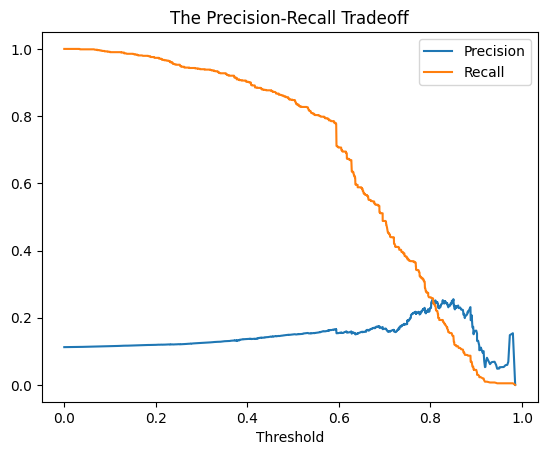

In [64]:
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt

# Get probabilities instead of hard predictions
probs = model.predict_proba(X_test)[:, 1]
precision, recall, thresholds = precision_recall_curve(y_true, probs)

plt.plot(thresholds, precision[:-1], label="Precision")
plt.plot(thresholds, recall[:-1], label="Recall")
plt.xlabel("Threshold")
plt.title("The Precision-Recall Tradeoff")
plt.legend()
plt.show()

In [65]:
# Instead of predictions = model.predict(X_test)
custom_threshold = 0.75  # Found from the chart above
custom_predictions = (probs >= custom_threshold).astype(int)

from sklearn.metrics import classification_report
print(classification_report(y_true, custom_predictions))

              precision    recall  f1-score   support

           0       0.91      0.80      0.85      6535
           1       0.19      0.38      0.25       828

    accuracy                           0.75      7363
   macro avg       0.55      0.59      0.55      7363
weighted avg       0.83      0.75      0.78      7363



In [66]:
from sklearn.metrics import f1_score
import numpy as np

# Calculate F1 for every threshold produced by the PR curve
f1_scores = 2 * (precision * recall) / (precision + recall + 1e-10)
best_idx = np.argmax(f1_scores)
best_threshold = thresholds[best_idx]

print(f"Optimal Threshold for F1: {best_threshold:.4f}")
print(f"Best achievable F1-Score: {f1_scores[best_idx]:.4f}")

# Apply this threshold
final_preds = (probs >= best_threshold).astype(int)
print(classification_report(y_true, final_preds))

Optimal Threshold for F1: 0.5937
Best achievable F1-Score: 0.2731
              precision    recall  f1-score   support

           0       0.95      0.50      0.66      6535
           1       0.17      0.78      0.27       828

    accuracy                           0.53      7363
   macro avg       0.56      0.64      0.46      7363
weighted avg       0.86      0.53      0.61      7363



In [36]:
# import pandas as pd

# # Get feature names from the preprocessor we fixed earlier
# feature_names = preprocessor.get_feature_names_out()
# importances = model.feature_importances_

# feat_imp = pd.Series(importances, index=feature_names).sort_values(ascending=False)
# print("Top 10 Most Important Features:")
# print(feat_imp.head(10))

In [67]:
from sklearn.metrics import matthews_corrcoef
import numpy as np

# 1. Get the probabilities
probs = model.predict_proba(X_test)[:, 1]

# 2. Test 100 different thresholds to find the best MCC
thresholds = np.linspace(0, 1, 100)
mcc_scores = [matthews_corrcoef(y_true, probs >= t) for t in thresholds]

# 3. Find the best one
best_threshold = thresholds[np.argmax(mcc_scores)]
best_mcc = max(mcc_scores)

print(f"Optimal Threshold for MCC: {best_threshold:.4f}")
print(f"Best MCC Score: {best_mcc:.4f}")

# 4. Generate the final report
final_predictions = (probs >= best_threshold).astype(int)
print(classification_report(y_true, final_predictions))

Optimal Threshold for MCC: 0.5859
Best MCC Score: 0.1763
              precision    recall  f1-score   support

           0       0.95      0.49      0.65      6535
           1       0.16      0.79      0.27       828

    accuracy                           0.53      7363
   macro avg       0.56      0.64      0.46      7363
weighted avg       0.86      0.53      0.61      7363



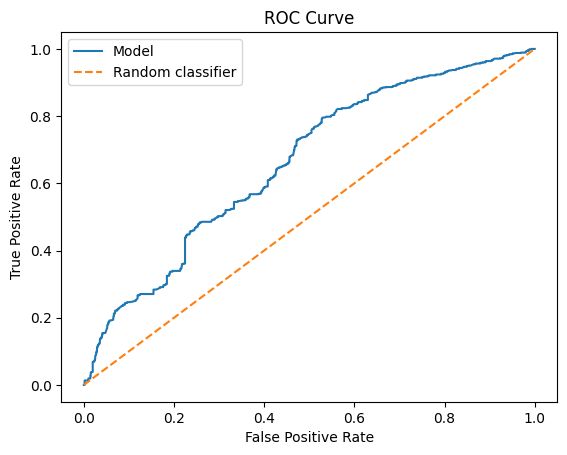

In [39]:
from sklearn.metrics import roc_curve

fpr, tpr, _ = roc_curve(y_true, probs)

plt.plot(fpr, tpr, label="Model")
plt.plot([0, 1], [0, 1], linestyle="--", label="Random classifier")

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()
